In [1]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt

from datasets import *
from geometry_matching import *

### Dataset generation

A parametric transformation and gaussian noise are applied on the blue point cloud. Some points are deleted and some fake points are also randomly added.

On the figures the 2nd point cloud is always translated along the x-axis to make the interpretation easier. In reality both point clouds are centered on $(0, 0)$.

In [2]:
np.random.seed(1234)

sigma = 1e-2
scaling_factor = 2.0
theta =np.pi/5

N1 = 25
N_fake = 10
N_deleted = 10
N2 = N1 - N_deleted + N_fake
T = 20 # Number of triangles selected per points in the first dataset
nNN=300 # Number of nearest triangles to extract

points1 = generate_points(N1)
points2 = transform_points(points1[N_deleted:], theta, scaling_factor, sigma)
fake_points2 = (np.random.rand(N_fake, 2) - 0.5)*(2*scaling_factor)

points2 = np.concatenate([points2, fake_points2], axis=0)

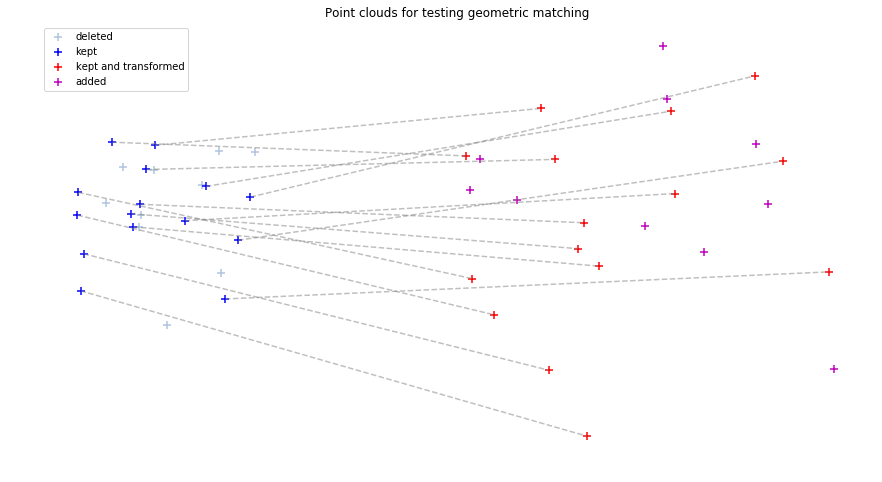

In [3]:
def draw_point_clouds(points1, points2, offset, N1, N_deleted, ax, with_mapping=True):
    N2_real = N1 - N_deleted
    ax.scatter(points1[:N_deleted,0], points1[:N_deleted,1], marker='+', s=60, color='lightsteelblue', label='deleted')
    ax.scatter(points1[N_deleted:,0], points1[N_deleted:,1], marker='+', s=60, color='b', label='kept')
    ax.scatter(points2[:N2_real,0] + offset, points2[:N2_real, 1], marker='+', s=60, color='r', label='kept and transformed')
    ax.scatter(points2[N2_real:,0] + offset, points2[N2_real:, 1], marker='+', s=60, color='m', label='added')
    ax.legend(loc=0)

    if with_mapping:
        for (x1,y1), (x2,y2) in zip(points1[N_deleted:], points2):
            ax.plot([x1,x2 + offset], [y1, y2], color='gray', linestyle='--', alpha=0.5)
    _ = ax.axis('off')

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
draw_point_clouds(points1, points2, 5., N1, N_deleted, ax)
_ = ax.set_title('Point clouds for testing geometric matching')

### Geometric features

In [6]:
# Extract t triangles per point in the first dataset 
triangles1, triangles1_indexes = pick_triangles(points1, T)
features1 = compute_features(triangles1.reshape((-1,3,2)))

# Extract all the possible triangles that can be built in the second dataset
triangles2 = extract_all_triangles(points2)
features2 = compute_features(triangles2.reshape((-1,3,2))).reshape((N2, N2, N2, 3))
for i in range(N2): # at least two points are identical
    features2[i, i, :] = -10 
    features2[:, i, i] = -10
    features2[i, :, i] = -10
      
# For each triangle in triangles1, extract nNN most similar triangles in triangles2
nearest_distances, nearest_neighbors = get_closest_features(features1, features2, nNN)

nearest_neighbors_indexes = np.concatenate([
    (nearest_neighbors.reshape((-1,1)) // (N2**2) % N2) ,
    (nearest_neighbors.reshape((-1,1)) // N2) % N2,
    nearest_neighbors.reshape((-1,1)) %  N2], axis = 1).reshape((-1, T, nNN, 3))

nearest_neighbors = nearest_neighbors.reshape((-1, T, nNN))

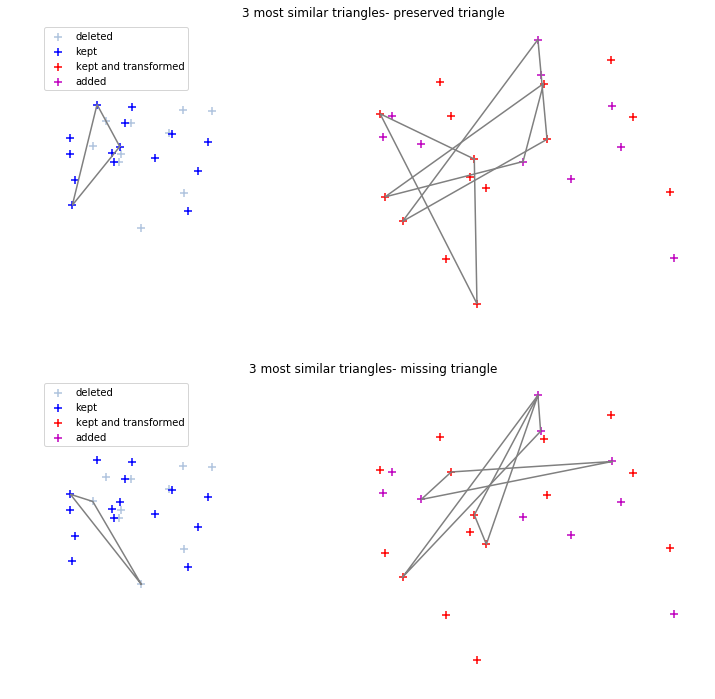

In [8]:
def draw_triangle(coordinates, ax):
    x = np.tile(coordinates[:, 0], 2)[:4]
    y = np.tile(coordinates[:, 1], 2)[:4]
    ax.plot(x, y, color='gray')
 
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
draw_point_clouds(points1, points2, 5., N1, N_deleted, ax[0], False)   
draw_point_clouds(points1, points2, 5., N1, N_deleted, ax[1], False)   

K = 3
p1, t1 = 10, 8 # 5-th triangle associated to the 2nd point
query_triangle = triangles1[p1][t1]
draw_triangle(query_triangle, ax[0])
nearest_triangles = triangles2.reshape((-1,6))[nearest_neighbors[p1][t1]].reshape((-1,3,2))
for triangle in nearest_triangles[:K]:
    draw_triangle(triangle + np.array([5., 0.]), ax[0])
    
ax[0].set_title(f'{K} most similar triangles- preserved triangle')


p2, t2 = 8, 7 # 5-th triangle associated to the 2nd point
query_triangle = triangles1[p2][t2]
draw_triangle(query_triangle, ax[1])
nearest_triangles = triangles2.reshape((-1,6))[nearest_neighbors[p2][t2]].reshape((-1,3,2))
for triangle in nearest_triangles[:K]:
    draw_triangle(triangle + np.array([5., 0.]), ax[1])
  
_ = ax[1].set_title(f'{K} most similar triangles- missing triangle')

In [11]:
# Compute potentials (similarity between triangles from the first dataset and the second one)
potentials = np.exp(-(nearest_distances / np.mean(nearest_distances)))
potentials = potentials.reshape((N1, T, nNN))

# Run power iteration algorithm one the potential to extract the mapping
mapping = power_iteration(triangles1_indexes, nearest_neighbors_indexes, potentials, N1, N2)

Epoch 1
||Vn - Vn_1|| = 24.0172618559455
Epoch 2
||Vn - Vn_1|| = 0.12061767821735296
Epoch 3
||Vn - Vn_1|| = 0.008403298084021137
Epoch 4
||Vn - Vn_1|| = 0.0012094180827928913
Epoch 5
||Vn - Vn_1|| = 0.00026935907278525714
Epoch 6
||Vn - Vn_1|| = 6.9936600230308e-05
Epoch 7
||Vn - Vn_1|| = 1.882579313407992e-05
Epoch 8
||Vn - Vn_1|| = 5.1110075226286524e-06
Stop after 7 iterations


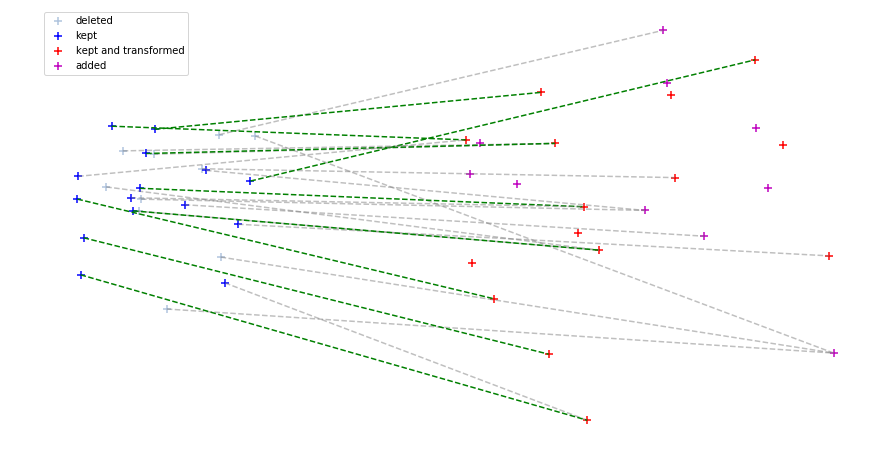

In [12]:
correctly_matched = mapping[N_deleted:] == np.arange(0, N1-N_deleted)
correctly_matched = np.concatenate([[False]*N_deleted, correctly_matched])

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
draw_point_clouds(points1, points2, 5., N1, N_deleted, ax, False)   

for i1, i2 in zip(np.arange(N1), mapping):
    ax.plot([points1[i1][0], points2[i2][0]+5.], [points1[i1][1], points2[i2][1]], 
            linestyle='--', color='g' if correctly_matched[i1] else 'gray', 
            alpha=1. if correctly_matched[i1] else 0.5)

In [13]:
print(f'Correct matches: {np.sum(correctly_matched)}/{N1-N_deleted}')

Correct matches: 9/15
